In [1]:
!pip install tensorflow-gpu

  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.


In [2]:
!nvidia-smi

Wed Jun 11 04:44:41 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   46C    P8              9W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [13]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torchvision
from torchvision import transforms, models
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import accuracy_score


In [3]:
import numpy as np
import pandas as pd
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        os.path.join(dirname, filename)

In [6]:
import kagglehub
orvile_brain_cancer_mri_dataset_path = kagglehub.dataset_download('orvile/brain-cancer-mri-dataset')
print('Data source import complete.')

Data source import complete.


In [10]:
import torchvision.transforms as transforms
import torchvision
import torch

LABELS = ['brain_tumor', 'brain_glioma', 'brain_menin']

# Define transformation
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# Load dataset
data_dir = orvile_brain_cancer_mri_dataset_path # Use the path from the previous cell
dataset = torchvision.datasets.ImageFolder(root=data_dir, transform=transform)

# Split dataset
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_data, test_data = torch.utils.data.random_split(dataset, [train_size, test_size])

In [11]:
BATCH_SIZE = 32

train_loader = torch.utils.data.DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False)


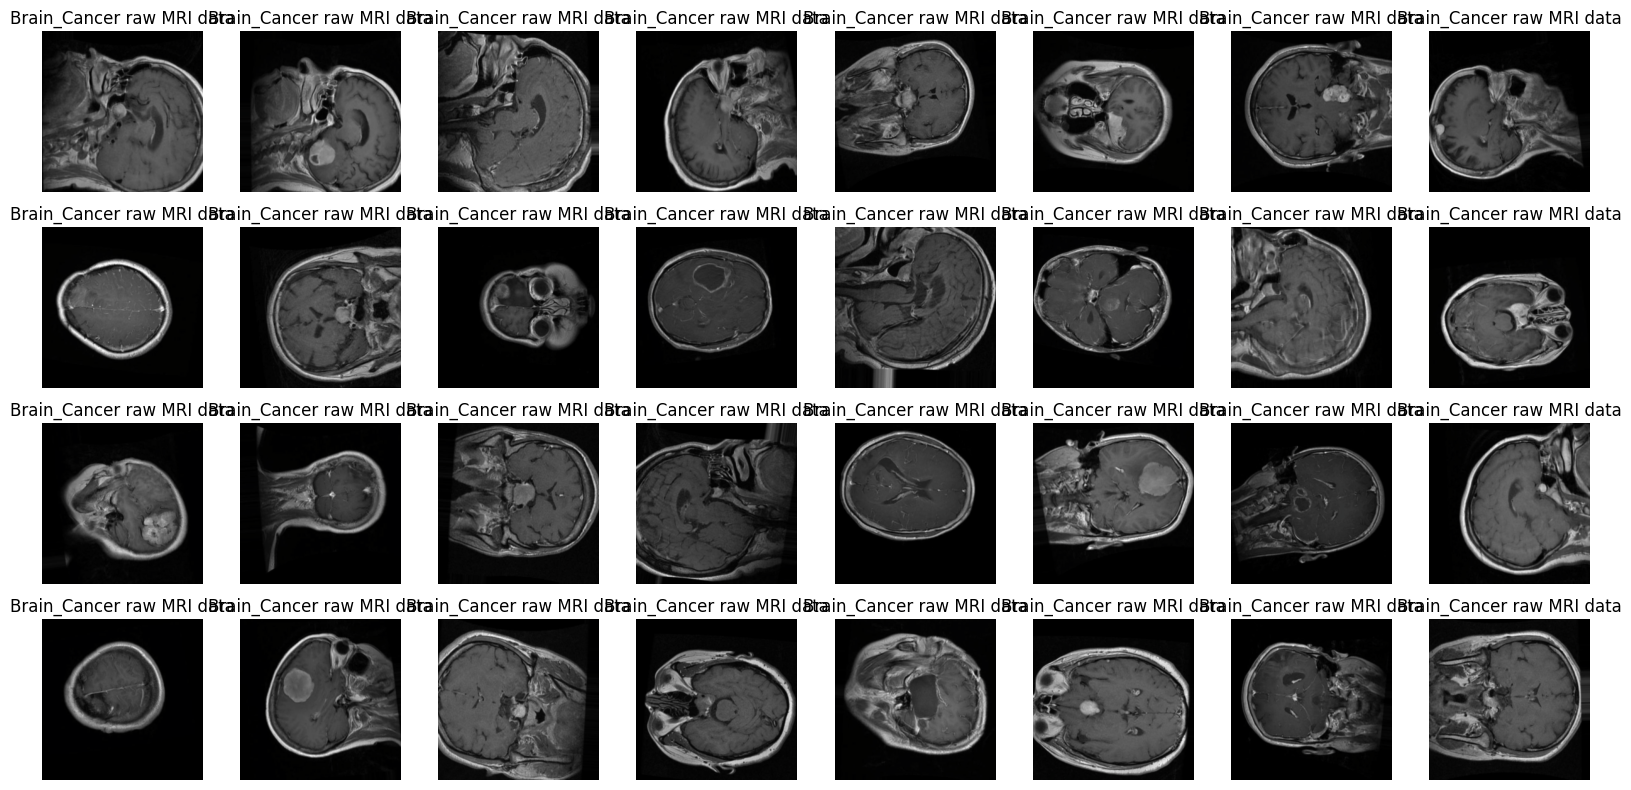

In [14]:
def img_inv(image):
    image = image.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = image * std + mean
    return np.clip(image, 0, 1)

images, labels = next(iter(train_loader))

fig, axs = plt.subplots(4, 8, figsize=(16, 8))
for i, ax in enumerate(axs.flat):
    ax.imshow(img_inv(images[i]))
    ax.set_title(dataset.classes[labels[i]])
    ax.axis("off")
plt.tight_layout()
plt.show()


In [15]:
# Using pretrained ResNet18
model = models.resnet18(pretrained=True)

# Freeze early layers (optional for better generalization)
for param in model.parameters():
    param.requires_grad = False

# Replace final layer
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, len(LABELS))

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 182MB/s]


In [16]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=0.001)


In [17]:
EPOCHS = 10

for epoch in range(EPOCHS):
    model.train()
    total_loss = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f'Epoch {epoch+1}/{EPOCHS}, Loss: {total_loss/len(train_loader):.4f}')


Epoch 1/10, Loss: 0.0122
Epoch 2/10, Loss: 0.0001
Epoch 3/10, Loss: 0.0001
Epoch 4/10, Loss: 0.0001
Epoch 5/10, Loss: 0.0000
Epoch 6/10, Loss: 0.0000
Epoch 7/10, Loss: 0.0000
Epoch 8/10, Loss: 0.0000
Epoch 9/10, Loss: 0.0000
Epoch 10/10, Loss: 0.0000


In [18]:
model.eval()
y_true = []
y_pred = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)

        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

accuracy = accuracy_score(y_true, y_pred)
print(f'Test Accuracy: {accuracy*100:.2f}%')


Test Accuracy: 100.00%


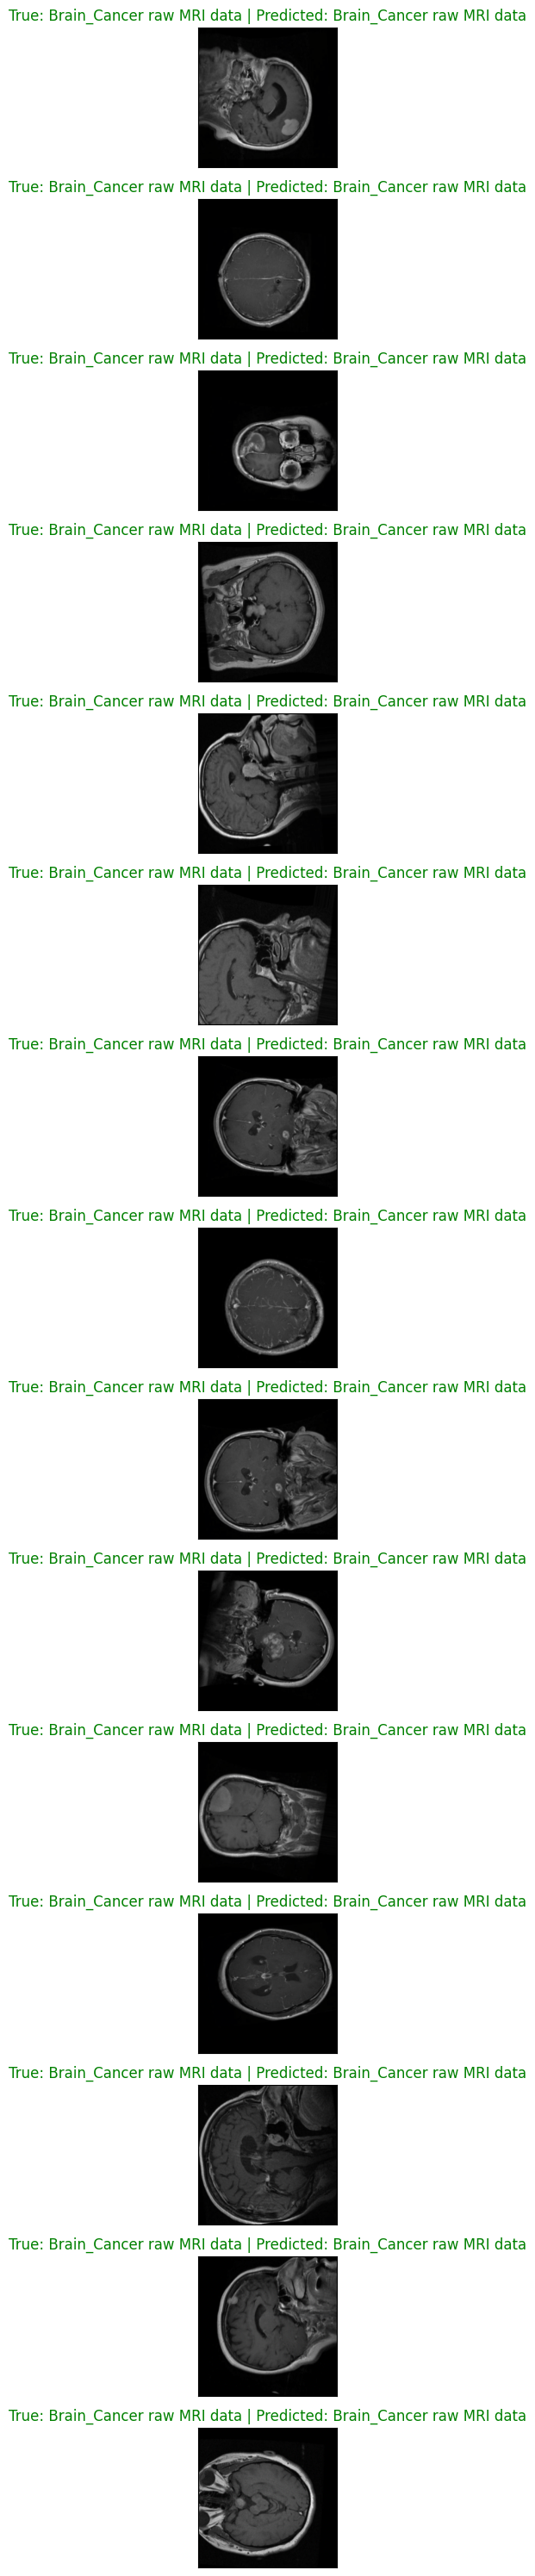

In [19]:
# Predict on test_data (single samples)
model.eval()
pred = []
y_test = []

for i in range(len(test_data)):
    image, label = test_data[i]
    image = image.unsqueeze(0).to(device)
    with torch.no_grad():
        output = model(image)
        _, predicted = torch.max(output, 1)
        pred.append(predicted.item())
        y_test.append(label)

# Display random predictions
rand_indices = np.random.choice(len(pred), size=min(15, len(pred)), replace=False)
plt.figure(figsize=(10, min(30, 2 * len(rand_indices))))

for i, index in enumerate(rand_indices):
    image_tensor = test_data[index][0].to('cpu')
    image = img_inv(image_tensor)
    plt.subplot(len(rand_indices), 1, i + 1)
    plt.imshow(image)
    plt.xticks([]), plt.yticks([])

    predicted_class = dataset.classes[int(pred[index])]
    true_class = dataset.classes[int(y_test[index])]
    color = 'green' if predicted_class == true_class else 'red'
    plt.title(f'True: {true_class} | Predicted: {predicted_class}', color=color, fontsize=12)

plt.tight_layout()
plt.show()
